In [37]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [49]:
COOKIES = {"steamLoginSecure": ""}  # insert a steam cookie here

In [51]:
def request(item: str, appid: int=730):
    """
    Requests price history data from the Steam Market API of a specific item and turns it into a dataframe.
    input:
        item: Market hash name of the requested item
        appid: ID of the market you want too request. CounterStrike (730), Dota (570) or TF2 (440)
    output:
        true (bool): If the request was successful
        df (pd.DataFrame): the transformed dataframe from the request data
        item (str): The hash name of the item
    """

    # Set different IDs
    if appid == "Dota":
        appid = 570  # Dota 2
    elif appid == "TF2":
        appid = 440  # TeamFortress 2

    # used LLM
    headers = {
        "Referer": f"https://steamcommunity.com/market/listings/{appid}/{item}",
        "User-Agent": "DataScience Project for University about Price Changes in virtuel item markets",
    }

    # used LLM
    params = {
        "appid": appid,
        "market_hash_name": item,
        "currency": 3, # 3 = EUR
    }

    # used LLM
    response = requests.get(
        "https://steamcommunity.com/market/pricehistory/",
        headers=headers,
        cookies=COOKIES,
        params=params,
        timeout=50,
    )

    print(item, response.status_code)

    # Transform date from string into date Datatype and change the format to yyyy-mm-dd
    if response.status_code == 200:
        df = pd.DataFrame(response.json()["prices"])  # "prices"-key contains the data of date, price and volume
        df.columns = ["date", "price", "volume"]

        # used LLM to change the date format
        dt_str = df["date"].str.extract(
            r"^([A-Za-z]{3}\s+\d{1,2}\s+\d{4})", expand=False
        )
        df["date"] = pd.to_datetime(dt_str, format="%b %d %Y", errors="coerce")

        df["volume"] = df["volume"].astype(int)

        return True, df, item

    else:
        return False, item

In [81]:
def create_dataset(items: list[str], date_start: str, date_end: str, columns: str="volume", make_csv: str="", appid: int=730):
    """
    Creates a new dataset of a list of items.
    input:
        items: List of items which contains item hash names
        date_start: Set a start date with the format (YYYY-MM-DD)
        date_end: Set an end date with the format (YYYY-MM-DD)
        columns: Set the column which u want to remove ("price" or "volume")
        make_csv: Set the name and create an CSV file if the string is not empty
        appid: Set the market u want to access (see requests-Method above)
    output:
        dataFrame (pd.DataFrame): Dataframe with the date as index/row, hash name as column and the price or volume as its value
    """

    # Dictionary for merge all the dataframe to one dataframe
    data = {}

    for skin in items:
        req = request(skin, appid)
        if req[0]:  #  True or False, if the request was successfull or not
            df = req[1]  # the dataframe we want to transform
            df = df.drop(columns=columns)
            df = df.set_index("date")

            df = df.groupby(level=0).mean(numeric_only=True)  # groups entries by date; used LLM
            
            df = df.loc[date_start:date_end]
            df.columns = [skin]
            data[skin] = df

    dataFrame = pd.concat(data.values(), axis=1, sort=True)  # merges all entries to one dataframe; used LLM

    # creates a csv if set in the parameters
    if not (make_csv == ""):
        path = f"data\\Visual_data\\{make_csv}.csv"

        dataFrame.to_csv(path, float_format="%.2f")  # used LLM for float_format

    return dataFrame

In [75]:
def import_dataset(name: str, date_start: str="", date_end: str=""):
    """
    Imports a dataset
    input:
        name: name of the CSV file
        date_start: Set a date start
        date_end: Set a date end
    output:
        df (pd.DataFrame): returns the imported CSV as a dataframe
    """

    path = f"data\\Visual_data\\{name}.csv"
    df = pd.read_csv(
        path, index_col="date", parse_dates=["date"]  # used LLM for parse_dates
    )

    if not (date_start == "" and date_end == ""):
        return df[(df.index >= date_start) & (df.index <= date_end)]
    else:
        return df

In [87]:
def add_to_dataset(items: list[str], name: str, overwrite: bool=False):
    """
    Adds more data to an existing dataset
    input:
        items (list): List of hash names you want to add to the dataset
        name (str): name of the csv file (without ".csv")
        overwrite (bool): overwrite the dataset with the new added data if true
    output:
        df (pd.DataFrame): returns a dataframe with the old and new data
    """
    df_old = import_dataset(name)

    # checks if the item data is already in the dataset. If so then it will be skipped
    new_item_list = []
    for skin in items:
        if not skin in df_old.columns:
            new_item_list += [skin]

    df_new = create_dataset(new_item_list, "2010-11-05", "2034-12-28")
    df = (
        pd.concat([df_old, df_new], axis=1).groupby(level=0).last()
    )  # merges the old and new datasets

    # overwrites the old CSV if wanted
    if overwrite:
        path = f"data\\Visual_data\\{name}.csv"

        df.to_csv(path, float_format="%.2f")

    return df

In [59]:
def navigate(df: pd.DataFrame, items: list[str]=[], date_start: str="2010-11-05", date_end: str="2034-12-28"):
    """
    Navigate through a dataset and choose just specific items u want to have in it and a specific date range to make it smaller
    input:
        df: a dataFrame (imported or created with the methods above)
        items: List of items you want to have in the dataframe
        date_start: Set a start date
        date_end: Set an end date
    output:
        df (pd.DataFrame): the new dataFrame
    """
    if items == []:
        return df.loc[date_start:date_end]
    return df[items].loc[date_start:date_end]

In [101]:
# This is a cell in which we are working with the methods above to create datasets, add data to it
# and use it for the visualizations further at the bottom


# different lists of item hash names
items = [
    "Berlin 2019 Overpass Souvenir Package",
    "Berlin 2019 Mirage Souvenir Package",
    "Antwerp 2022 Nuke Souvenir Package",
    "Paris 2023 Inferno Souvenir Package",
]


items = [
    "AK-47 | Bloodsport (Field-Tested)",
    "AK-47 | Fuel Injector (Field-Tested)",
    "AK-47 | Redline (Field-Tested)",
    "AWP | Asiimov (Field-Tested)",
    "AUG | Chameleon (Field-Tested)",
    "AWP | Hyper Beast (Field-Tested)",
    "CZ75-Auto | Victoria (Field-Tested)",
    "Desert Eagle | Blaze (Factory New)",
    "FAMAS | Roll Cage (Field-Tested)",
    "M4A1-S | Cyrex (Field-Tested)",
    "M4A1-S | Hyper Beast (Field-Tested)",
]


items = [
    "Berlin 2019 Overpass Souvenir Package",
    "Berlin 2019 Mirage Souvenir Package",
    "Paris 2023 Inferno Souvenir Package",
    "Berlin 2019 Dust II Souvenir Package",
    "Berlin 2019 Inferno Souvenir Package",
    "Stockholm 2021 Dust II Souvenir Package",
    "Stockholm 2021 Mirage Souvenir Package",
    "Stockholm 2021 Inferno Souvenir Package",
    "Antwerp 2022 Dust II Souvenir Package",
    "Antwerp 2022 Mirage Souvenir Package",
    "Antwerp 2022 Inferno Souvenir Package",
    "Rio 2022 Dust II Souvenir Package",
    "Rio 2022 Mirage Souvenir Package",
    "Rio 2022 Inferno Souvenir Package",
    "Paris 2023 Mirage Souvenir Package",
    "Spectrum Case",
    "Clutch Case",
    "Horizon Case",
    "Danger Zone Case",
    "Spectrum 2 Case",
    "London 2018 Dust II Souvenir Package",
]
items = [
    "Berlin 2019 Overpass Souvenir Package",
    "Berlin 2019 Mirage Souvenir Package",
    "Antwerp 2022 Nuke Souvenir Package",
    "Paris 2023 Inferno Souvenir Package",
]


#df = create_dataset(items, "2010-11-05", "2034-12-28", make_csv="Cases")
#df = add_to_dataset(items, "Cases", True)


df = import_dataset("Big_data_set_price")
# df = df.dropna()
# df = df.ffill() # fills NaN Values with the Value before


#df = navigate(df, items, date_start="2014-09-20", date_end="2026-12-28")


df

,CZ75-Auto | Victoria (Factory New),CZ75-Auto | Tigris (Factory New),CZ75-Auto | Crimson Web (Factory New),CZ75-Auto | Tread Plate (Factory New),CZ75-Auto | The Fuschia Is Now (Factory New),CZ75-Auto | Poison Dart (Factory New),Desert Eagle | Blaze (Factory New),AK-47 | Vulcan (Minimal Wear),AWP | Atheris (Field-Tested),AK-47 | Vulcan (Factory New),...,SG 553 | Tiger Moth (Field-Tested),SSG 08 | Blood in the Water (Field-Tested),SSG 08 | Dragonfire (Field-Tested),Tec-9 | Avalanche (Field-Tested),Tec-9 | Fuel Injector (Field-Tested),Tec-9 | Nuclear Threat (Field-Tested),USP-S | Kill Confirmed (Field-Tested),USP-S | Neo-Noir (Field-Tested),USP-S | Printstream (Field-Tested),USP-S | The Traitor (Field-Tested)
date,,,,,,,,,,,,,,,,,,,,,
2013-08-15,NaN,NaN,NaN,NaN,NaN,NaN,18.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.65,NaN,NaN,NaN,NaN
2013-08-16,NaN,NaN,NaN,NaN,NaN,NaN,17.49,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.34,NaN,NaN,NaN,NaN
2013-08-17,NaN,NaN,NaN,NaN,NaN,NaN,18.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.42,NaN,NaN,NaN,NaN
2013-08-18,NaN,NaN,NaN,NaN,NaN,NaN,14.65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.15,NaN,NaN,NaN,NaN
2013-08-19,NaN,NaN,NaN,NaN,NaN,NaN,14.34,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.79,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-18,19.03,3.48,10.85,5.69,39.54,NaN,NaN,NaN,4.92,NaN,...,1.34,NaN,16.93,2.39,5.14,47.54,74.56,15.63,34.25,14.51
2025-09-19,17.73,3.35,NaN,9.30,NaN,10.10,125.75,NaN,4.86,NaN,...,1.21,64.37,17.03,2.29,5.16,NaN,73.31,15.79,34.37,14.11
2025-09-20,18.25,3.13,NaN,5.36,39.17,10.22,1038.96,550.01,4.88,1028.32,...,1.30,63.21,17.56,2.43,5.03,54.91,77.23,15.74,34.24,14.28


In [9]:
# smoothing data by average of 'window' days
window = 14


for col in df.columns:
    df[col] = df[col].rolling(window=window, min_periods=1).mean()  # used LLM

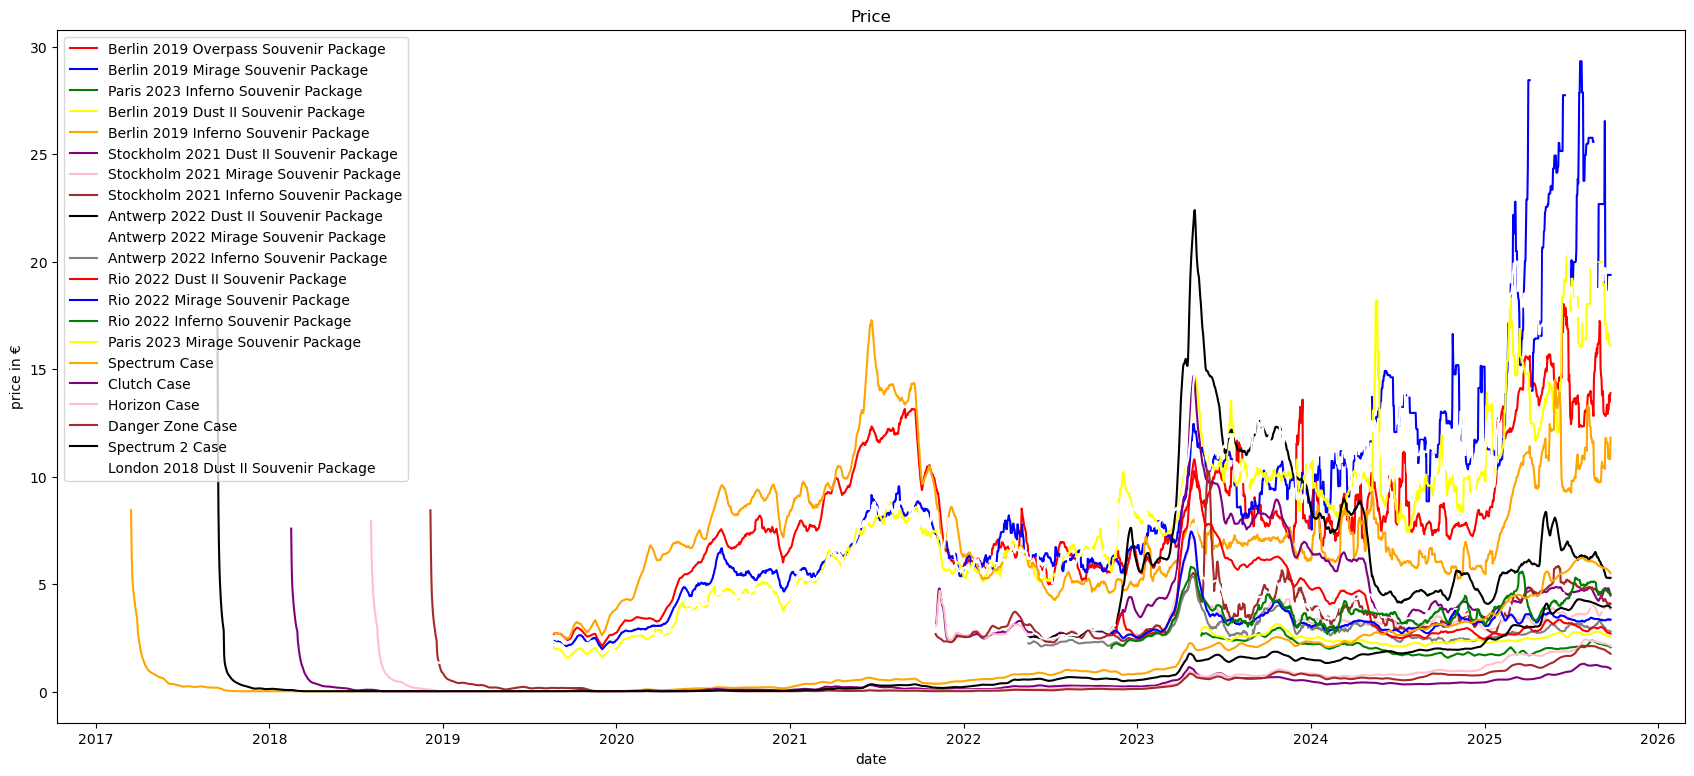

In [10]:
# plot everything in one graph


colors = [
    "red",
    "blue",
    "green",
    "yellow",
    "orange",
    "purple",
    "pink",
    "brown",
    "black",
    "white",
    "gray",
]

plt.figure(figsize=(21, 9))
for i, item in enumerate(df.columns):
    plt.plot(df.index, df[item], color=colors[i % len(colors)], label=item)
plt.xlabel("date")
plt.ylabel("price in €")
plt.title("Price")

plt.legend()
plt.show()

In [11]:
print(df.columns)

Index(['Berlin 2019 Overpass Souvenir Package',
       'Berlin 2019 Mirage Souvenir Package',
       'Paris 2023 Inferno Souvenir Package',
       'Berlin 2019 Dust II Souvenir Package',
       'Berlin 2019 Inferno Souvenir Package',
       'Stockholm 2021 Dust II Souvenir Package',
       'Stockholm 2021 Mirage Souvenir Package',
       'Stockholm 2021 Inferno Souvenir Package',
       'Antwerp 2022 Dust II Souvenir Package',
       'Antwerp 2022 Mirage Souvenir Package',
       'Antwerp 2022 Inferno Souvenir Package',
       'Rio 2022 Dust II Souvenir Package', 'Rio 2022 Mirage Souvenir Package',
       'Rio 2022 Inferno Souvenir Package',
       'Paris 2023 Mirage Souvenir Package', 'Spectrum Case', 'Clutch Case',
       'Horizon Case', 'Danger Zone Case', 'Spectrum 2 Case',
       'London 2018 Dust II Souvenir Package'],
      dtype='object')


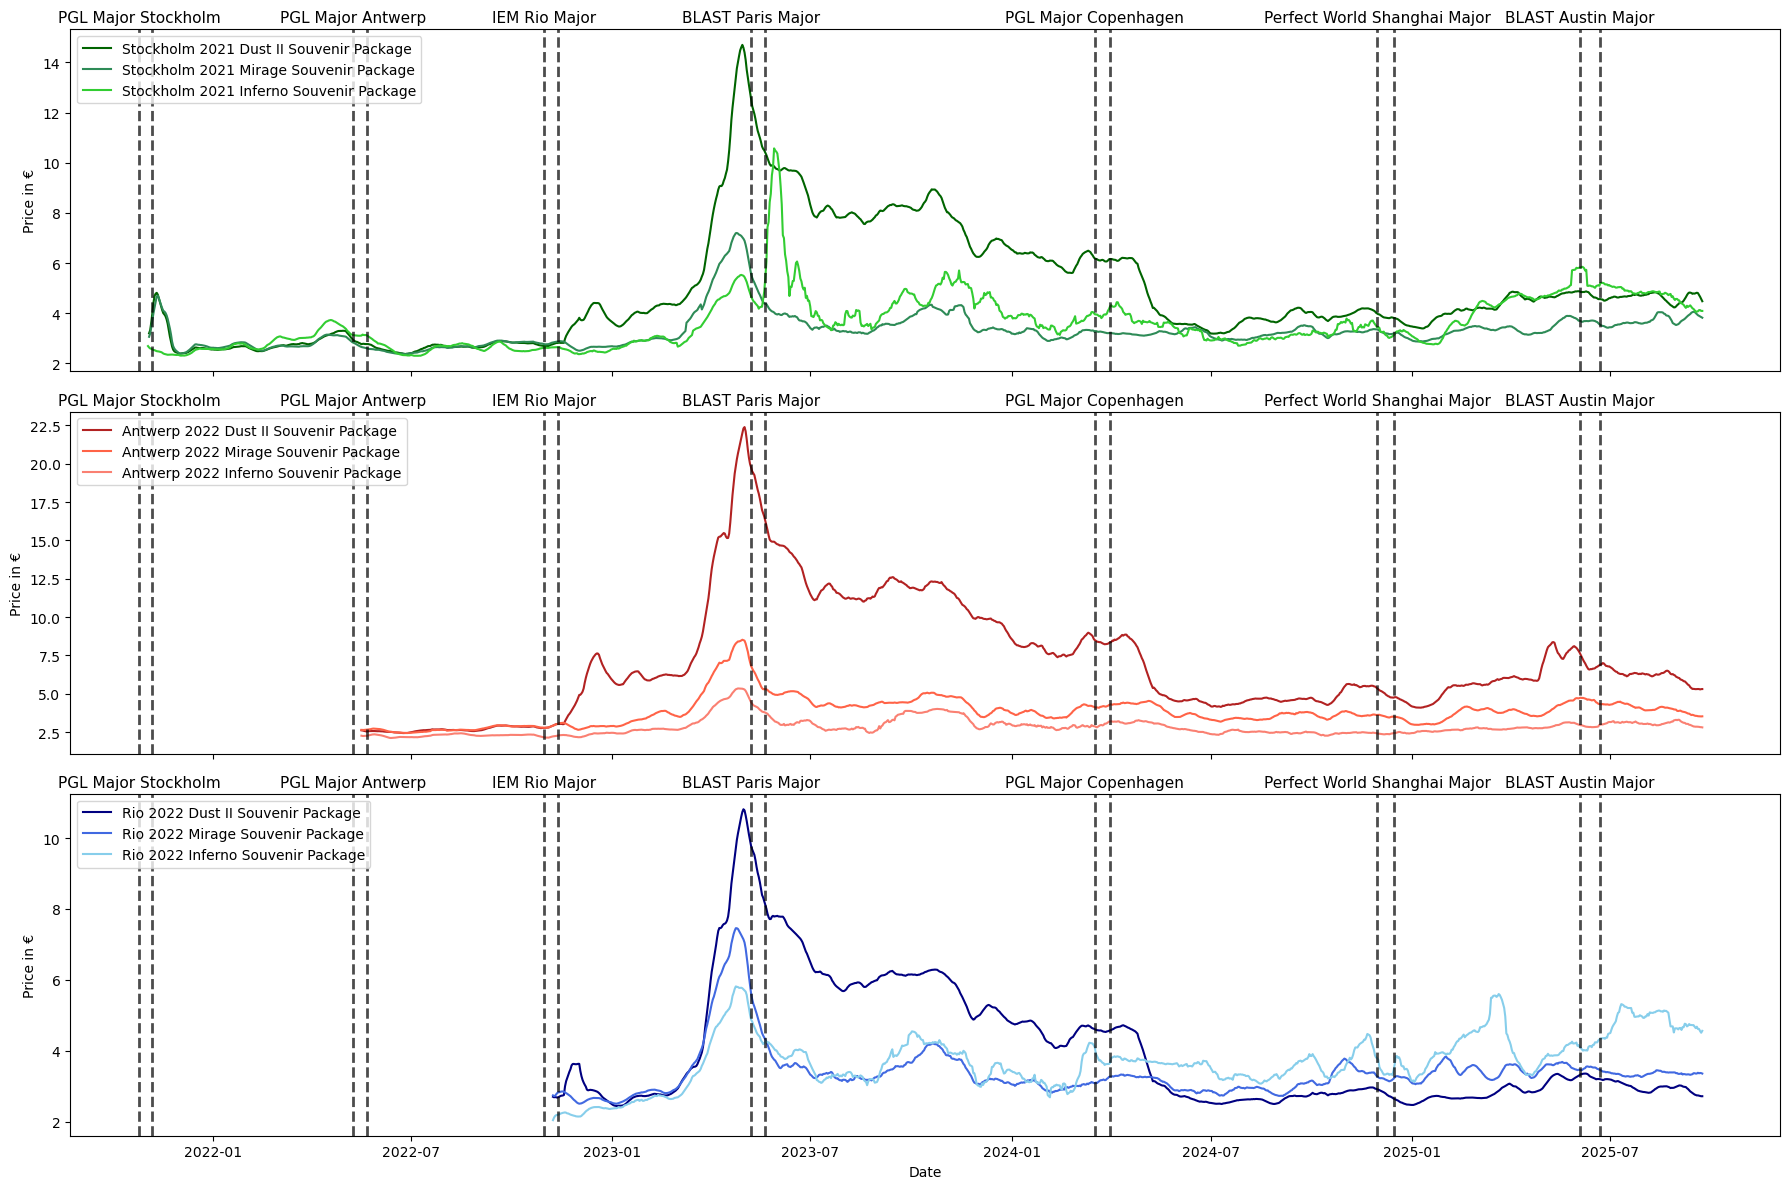

In [12]:
# plots different itemprices in subplots and add event lines to specific dates

subplots_num = 3
plots = {}  # contains the items hashnames for the specific subplot

plots[1] = [
    "Stockholm 2021 Dust II Souvenir Package",
    "Stockholm 2021 Mirage Souvenir Package",
    "Stockholm 2021 Inferno Souvenir Package",
]
plots[2] = [
    "Antwerp 2022 Dust II Souvenir Package",
    "Antwerp 2022 Mirage Souvenir Package",
    "Antwerp 2022 Inferno Souvenir Package",
]
plots[3] = [
    "Rio 2022 Dust II Souvenir Package",
    "Rio 2022 Mirage Souvenir Package",
    "Rio 2022 Inferno Souvenir Package",
]

# patches contains the event labels and a line on a specific date
patches = {}
patches["PGL Major Stockholm"] = "2021-10-26"
patches[" "] = "2021-11-07"
patches["PGL Major Antwerp"] = "2022-05-09"
patches["  "] = "2022-05-22"
patches["IEM Rio Major"] = "2022-10-31"
patches["   "] = "2022-11-13"
patches["BLAST Paris Major"] = "2023-05-08"
patches["    "] = "2023-05-21"
patches["PGL Major Copenhagen"] = "2024-03-17"
patches["     "] = "2024-03-31"
patches["Perfect World Shanghai Major"] = "2024-11-30"
patches["      "] = "2024-12-15"
patches["BLAST Austin Major"] = "2025-06-03"
patches["       "] = "2025-06-22"

# colors you want wo use for each subplot
colors = {}
colors[1] = ["darkgreen", "seagreen", "limegreen"]
colors[2] = ["firebrick", "tomato", "salmon"]
colors[3] = ["navy", "royalblue", "skyblue"]

titles = [" ", " ", " "]


fig, axes = plt.subplots(subplots_num, 1, figsize=(18, 12), sharex=True)

# plot the items for each subplot
for i in range(subplots_num):
    for c, skin in enumerate(plots[i + 1]):
        axes[i].plot(df[skin].index, df[skin], color=colors[i + 1][c], label=skin)
    axes[i].set_ylabel("Price in €")
    axes[i].set_title(titles[i], fontweight="bold")
    axes[i].legend()
    axes[i].legend(loc="upper left")


# plot the event names and lines; used LLM to plot the event lines and change the label position if necessary
for ax in axes:
    ylim = ax.get_ylim()
    for label, date in patches.items():

        x = pd.to_datetime(date)
        x_offset = pd.Timedelta(0)

        # if some labels overlap, then move them by changing the days in Timedelta
        if label == "CS2 Beta":  # old labels
            x_offset = pd.Timedelta(days=-10)
        elif label == "CS update to CS2":
            x_offset = pd.Timedelta(days=20)

        ax.axvline(x, color="black", linestyle="--", linewidth=2, alpha=0.7)
        ax.text(
            x + x_offset,
            ylim[1] * 1.01,
            label,
            ha="center",
            va="bottom",
            fontsize=11,
            rotation=0,
            color="black",
        )


axes[len(plots) - 1].set_xlabel("Date")

plt.tight_layout()  # used LLM
# plt.savefig("Graphiken\\Majors_Souvenir_Cases.png", dpi=300)
plt.show()

In [13]:
df.columns

Index(['Berlin 2019 Overpass Souvenir Package',
       'Berlin 2019 Mirage Souvenir Package',
       'Paris 2023 Inferno Souvenir Package',
       'Berlin 2019 Dust II Souvenir Package',
       'Berlin 2019 Inferno Souvenir Package',
       'Stockholm 2021 Dust II Souvenir Package',
       'Stockholm 2021 Mirage Souvenir Package',
       'Stockholm 2021 Inferno Souvenir Package',
       'Antwerp 2022 Dust II Souvenir Package',
       'Antwerp 2022 Mirage Souvenir Package',
       'Antwerp 2022 Inferno Souvenir Package',
       'Rio 2022 Dust II Souvenir Package', 'Rio 2022 Mirage Souvenir Package',
       'Rio 2022 Inferno Souvenir Package',
       'Paris 2023 Mirage Souvenir Package', 'Spectrum Case', 'Clutch Case',
       'Horizon Case', 'Danger Zone Case', 'Spectrum 2 Case',
       'London 2018 Dust II Souvenir Package'],
      dtype='object')

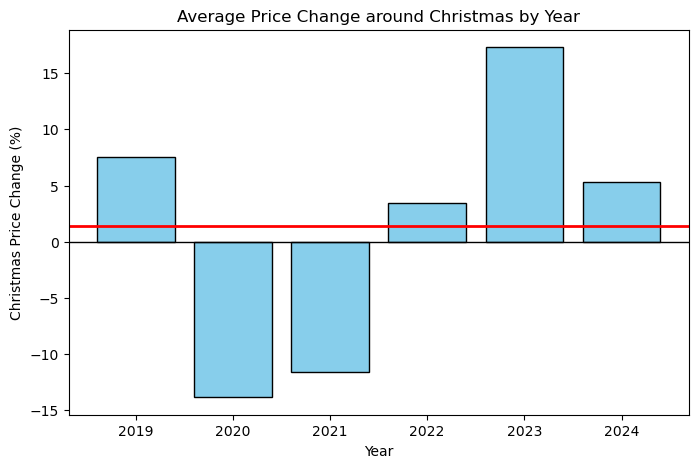

In [14]:
# calculates the price change over a fix time period (like christmas) over the years

item = "Berlin 2019 Overpass Souvenir Package"


# V is the first time slot
startV = "2015-11-15"
endV = "2015-12-06"

# N is the second time slot
startN = "2015-12-07"
endN = "2015-12-31"


values = []  # contains the caluculated values from the years
year = pd.DataFrame()
year["year"] = [2016 + i for i in range(9)]
# print(year)

for i in range(len(year["year"].values)):

    # just changes the years at the strings
    startV = str(year["year"][i]) + startV[4:]
    startN = str(year["year"][i]) + startN[4:]
    endV = str(year["year"][i]) + endV[4:]
    endN = str(year["year"][i]) + endN[4:]

    # calculation
    avgV = np.mean(df[(df.index >= startV) & (df.index <= endV)][item])
    avgN = np.mean(df[(df.index >= startN) & (df.index <= endN)][item])

    values += [(avgN - avgV) / avgV * 100]

    # print(startV, startN, endV, endN)
    # print(avgV)


year["value"] = values
# print(year)

# plot the values
plt.figure(figsize=(8, 5))
plt.bar(year["year"], year["value"], color="skyblue", edgecolor="black")
plt.axhline(0, color="black", linestyle="-", linewidth=1)

# calculate the mean from all values and plots it as a red line
avg = np.mean(year["value"])
plt.axhline(
    avg, color="red", linestyle="-", linewidth=2, label=f"Average ({avg:.2f}%)"
)  # used LLM for linestyle, linewidth


plt.xlabel("Year")
plt.ylabel("Christmas Price Change (%)")
plt.title("Average Price Change around Christmas by Year")


# if you want to save the graph with its name, then you need to replace the "|"
item = re.sub(r"[|]", "_", item)

# plt.savefig(f"Graphiken\\Seasonal_Trends\\Christmas_Price_Change\\{item}.png", dpi=300)
plt.show()

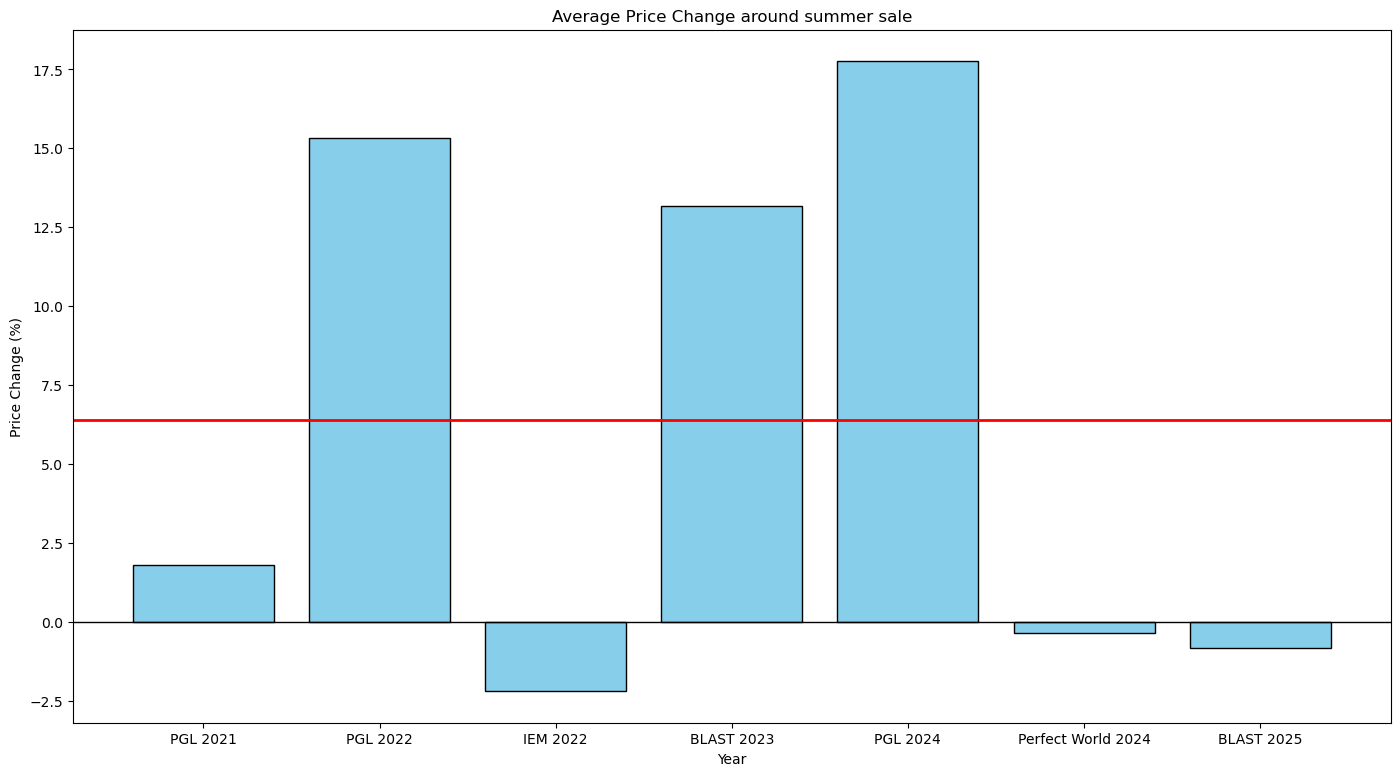

In [15]:
# calculates the price change over a variable time period (like events) over the events


item = "Berlin 2019 Overpass Souvenir Package"

# set the values for the x-axes
l = [
    "IEM Katowice 2019",
    "StarLadder 2019",
    "PGL 2021",
    "PGL 2022",
    "IEM 2022",
    "BLAST 2023",
    "PGL 2024",
    "Perfect World 2024",
    "BLAST 2025",
]


values = []  # contains the caluculated values from the majors
year = pd.DataFrame()
year["major"] = l

dates = {}

# set the dates manually with the start and end of both timeslots
dates_start_end = [
    (("2019-01-15", "2019-01-31"), ("2019-01-31", "2019-02-13")),
    (("2019-07-23", "2019-08-08"), ("2019-08-08", "2019-08-23")),
    (("2021-09-26", "2021-10-11"), ("2021-10-11", "2021-10-26")),
    (("2022-04-09", "2022-04-24"), ("2022-04-24", "2022-05-09")),
    (("2022-09-30", "2022-10-15"), ("2022-10-15", "2022-10-31")),
    (("2023-04-08", "2023-04-23"), ("2023-04-23", "2023-05-08")),
    (("2024-02-17", "2024-03-02"), ("2024-03-02", "2024-03-17")),
    (("2024-10-30", "2024-11-15"), ("2024-11-15", "2024-11-30")),
    (("2025-05-03", "2025-05-18"), ("2025-05-18", "2025-06-03")),
]


# add the dates to the x-axe values
for i, skin in enumerate(l):
    dates[skin] = dates_start_end[i]


startV = ""
startN = ""
endV = ""
endN = ""


# calculates the price change for the dates
for i, skin in enumerate(l):

    startV = dates[skin][0][0]
    endV = dates[skin][0][1]

    startN = dates[skin][1][0]
    endN = dates[skin][1][1]

    avgV = np.mean(df[(df.index >= startV) & (df.index <= endV)][item])
    avgN = np.mean(df[(df.index >= startN) & (df.index <= endN)][item])
    values += [(avgN - avgV) / avgV * 100]

    # print(startV, startN, endV, endN)
    # print(avgV)


year["value"] = values

# plot the bars
plt.figure(figsize=(17, 9))
plt.bar(year["major"], year["value"], color="skyblue", edgecolor="black")
plt.axhline(0, color="black", linestyle="-", linewidth=1)

# calculate the average of all events and plot it as a red line
avg = np.mean(year["value"])
plt.axhline(avg, color="red", linestyle="-", linewidth=2, label=f"Average ({avg:.2f}%)")


plt.xlabel("Year")
plt.ylabel("Price Change (%)")
plt.title("Average Price Change around summer sale")


item = re.sub(r"[|]", "_", item)

# plt.savefig(f"Graphiken\\Events\\Major_price_change\\{item}.png", dpi=300)
plt.show()

In [16]:
# Used LLM here to make an aggregated plot of all items in a dataset


normalized_CS = df.copy().apply(
    lambda x: (x / x.iloc[0]) * 100
)  # normalize the values based on the first value
avg_trend_CS = normalized_CS.mean(axis=1)

normalized_CS_minmax = df.copy().apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)  # normalize by the min and max values
avg_trend_CS_minmax = normalized_CS_minmax.mean(axis=1)

# calculate the mean and put it into the dataframe to use it for visualizations above
df["average"] = df.copy().mean(axis=1)
df

,Berlin 2019 Overpass Souvenir Package,Berlin 2019 Mirage Souvenir Package,Paris 2023 Inferno Souvenir Package,Berlin 2019 Dust II Souvenir Package,Berlin 2019 Inferno Souvenir Package,Stockholm 2021 Dust II Souvenir Package,Stockholm 2021 Mirage Souvenir Package,Stockholm 2021 Inferno Souvenir Package,Antwerp 2022 Dust II Souvenir Package,Antwerp 2022 Mirage Souvenir Package,...,Rio 2022 Mirage Souvenir Package,Rio 2022 Inferno Souvenir Package,Paris 2023 Mirage Souvenir Package,Spectrum Case,Clutch Case,Horizon Case,Danger Zone Case,Spectrum 2 Case,London 2018 Dust II Souvenir Package,average
date,,,,,,,,,,,,,,,,,,,,,
2017-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.450000,NaN,NaN,NaN,NaN,NaN,8.450000
2017-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.950000,NaN,NaN,NaN,NaN,NaN,6.950000
2017-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.940000,NaN,NaN,NaN,NaN,NaN,5.940000
2017-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.245000,NaN,NaN,NaN,NaN,NaN,5.245000
2017-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.904000,NaN,NaN,NaN,NaN,NaN,4.904000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-19,13.131429,19.385,2.123571,16.6600,10.838889,4.805000,3.922143,4.075000,5.306429,3.531429,...,3.377143,4.612857,2.606429,5.626429,1.130714,2.187143,1.831429,3.996429,17.238,6.284194
2025-09-20,13.802857,19.385,2.125000,16.2200,11.207500,4.734286,3.895714,4.124545,5.304615,3.525000,...,3.362857,4.612857,2.598571,5.597857,1.120000,2.173571,1.814286,3.985714,17.746,6.328817
2025-09-21,13.477143,19.385,2.107857,16.1075,11.083333,4.655714,3.873571,4.124545,5.280000,3.520714,...,3.371429,4.553333,2.588571,5.575000,1.107143,2.162143,1.797857,3.970714,17.964,6.297442


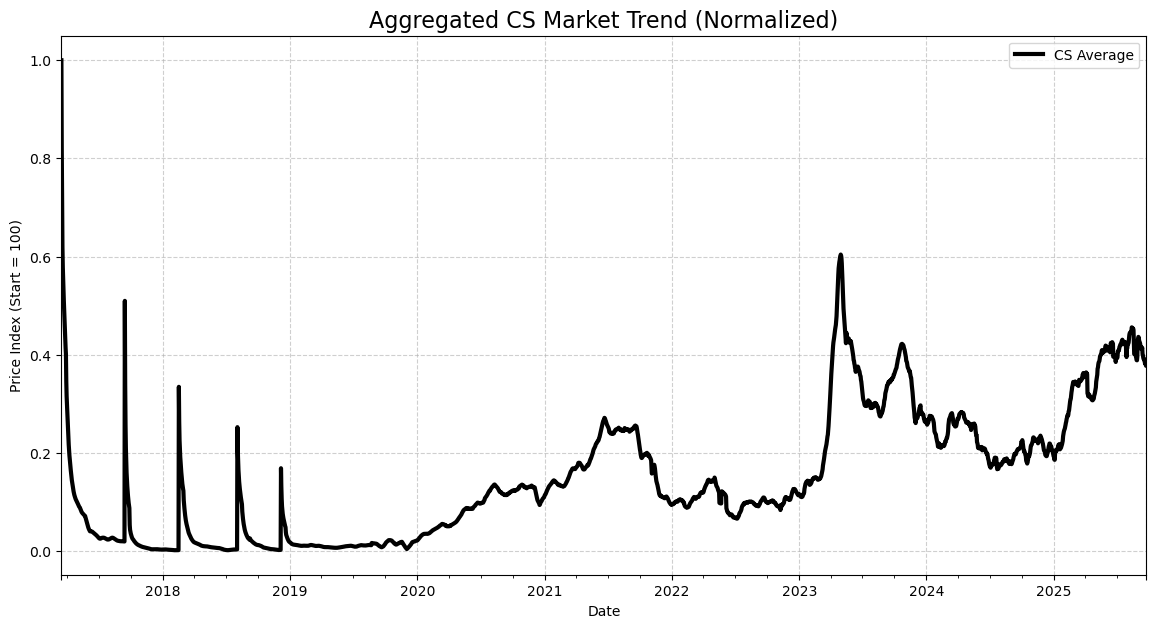

In [17]:
# print(avg_trend_CS, avg_trend_CS_minmax)


plt.figure(figsize=(14, 7))

# choose which one to plot
# avg_trend_CS.plot(color="black", linewidth=3, label="CS Average")
avg_trend_CS_minmax.plot(color="black", linewidth=3, label="CS Average")

plt.title("Aggregated CS Market Trend (Normalized)", fontsize=16)
plt.ylabel("Price Index (Start = 100)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()